## Import modules

In [ ]:


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Reshape,Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils import load_img, img_to_array, array_to_img, to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

from IPython import display
print ("tensorflow version: ", tensorflow.__version__ )

tensorflow version:  2.9.2


In [ ]:

tensorflow.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15525071090132665420
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8008378694094741532
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Load datasets

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data= pd.read_csv("/content/gdrive/MyDrive/FER-2013/fer2013.csv") 

data.shape

Mounted at /content/gdrive


(35887, 3)

In [ ]:

data.head() 

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Data preprocessing

In [ ]:
x_train_pixels=data.pixels.str.split(" ").tolist()   
x_train_pixels=pd.DataFrame(x_train_pixels, dtype= int)   

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
train_images = x_train_pixels.values

x_train = train_images.astype(np.float)  

print(x_train.shape)  

(35887, 2304)


<ipython-input-6-8b50ba3b8828>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = train_images.astype(np.float)  #Let's change the type of the variable


In [ ]:
x_train=x_train.reshape(x_train.shape[0],48,48,1)
x_train.shape

(35887, 48, 48, 1)

### Visualize

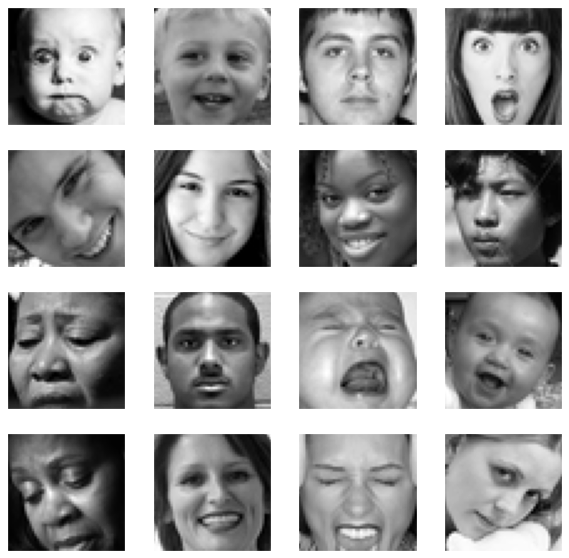

In [ ]:

plt.figure(figsize=(10,10))
for i in range (16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[np.random.randint(0,35880)][:,:,0] ,cmap='gray')

plt.show()

In [ ]:

def create_discriminator(in_shape=(48,48,1)):
    
    model= Sequential() 
    
    model.add(Conv2D(64,(3,3), strides=(2,2), padding= "same", input_shape= in_shape )) 
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128,(3,3), strides=(2,2), padding= "same"))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128,(3,3), strides=(2,2), padding= "same"))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(64,(3,3), strides=(2,2), padding= "same"))
    model.add(LeakyReLU(alpha=0.2))

    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))
    
    opt= Adam(learning_rate= 0.0001, beta_1=0.5)
    
    model.compile(loss= "binary_crossentropy",
                 optimizer=opt,
                 metrics=["accuracy"])
    
    return model

discriminatorx= create_discriminator() 
discriminatorx.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12, 12, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6, 6, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 64)          7

In [ ]:

def create_generator( latent_dim):
    
    model= Sequential()
    
    n_nodes=128*6*6 
    
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((6, 6, 128)))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= "same")) 
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding= "same")) 
    model.add(LeakyReLU(alpha=0.2))
              
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding= "same")) 
    model.add(LeakyReLU(alpha=0.2))
              
    model.add(Conv2D(1, (8,8), activation= "tanh", padding= "same"))
              
    return model
              
generatorx= create_generator(100) 
generatorx.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4608)              465408    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4608)              0         
                                                                 
 reshape (Reshape)           (None, 6, 6, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12, 12, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 24, 24, 64)       131136    
 ranspose)                                            

## Deep Convolutional Generative Adversarial Network (DCGAN)

In [ ]:

def create_gan(generator, discriminator):
    
    discriminator.trainable= False 
    
    model= Sequential() 
    

    
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss= "binary_crossentropy",
                 optimizer=Adam(learning_rate= 0.0001, beta_1=0.5))
    
    return model

In [ ]:


def load_real_samples():
    x_train
    X= (x_train.astype("float32")-127.5)/127.5
    
    return X

In [ ]:

latent_dim=100

discriminator =create_discriminator() 
generator = create_generator(latent_dim)
gan_model = create_gan(generator, discriminator)

dataset= load_real_samples() 

In [ ]:

def generate_real_samples(dataset, n_samples):
    
    ix= np.random.randint(0, dataset.shape[0], n_samples)  
    
    X= dataset[ix] 
    
    y= np.ones((n_samples,1)) 
    
    return X,y

In [ ]:


def generate_latent_points(latent_dim, n_samples):

    x_input = np.random.randn(latent_dim * n_samples) 

    x_input = x_input.reshape(n_samples, latent_dim) 
    return x_input

In [ ]:


def generate_fake_samples(generator, latent_dim, n_samples):
    
    x_input= generate_latent_points(latent_dim, n_samples) 
    
    X= generator.predict(x_input)
    
    y= np.zeros((n_samples,1)) 
    
    return X,y

In [ ]:
def generate_and_save_images(model, epoch, test_input):

  predictions= model(test_input, training=False) 

  fig= plt.figure(figsize=(10,10))

  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5*127.5 ) 
    plt.axis("off")

  plt.savefig("./produced_images_epoch_{:04d}.png".format(epoch)) 
  plt.show()

Text(0.5, 1.0, 'SEED')

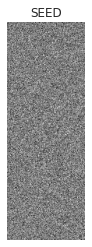

In [ ]:
n_batch=128 

num_epochs=int(dataset.shape[0]/n_batch)

seed= tensorflow.random.normal(shape=[num_epochs,100])

plt.imshow(seed, cmap="binary")
plt.axis("off")
plt.title("SEED")

In [ ]:

def train (g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=128):
    
    batch_per_epoch= int(dataset.shape[0]/n_batch) 
    half_batch= int(n_batch/2)
    
    for i in range (n_epochs):
        
        for j in range(batch_per_epoch):
            
  
            X_real, y_real= generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
            

            X_fake, y_fake= generate_fake_samples(g_model,latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            

            X_gan= generate_latent_points(latent_dim, n_batch)
            y_gan= np.ones((n_batch,1))
            
            g_loss= gan_model.train_on_batch(X_gan, y_gan)

        display.clear_output(wait=True) 
        generate_and_save_images(generator, i+1, seed) 

        print( "epochs: ", i)
    
    display.clear_output(wait=True) 
    generate_and_save_images(generator, i, seed) 
            
    g_model.save("./face_generator.h5") 

## Training

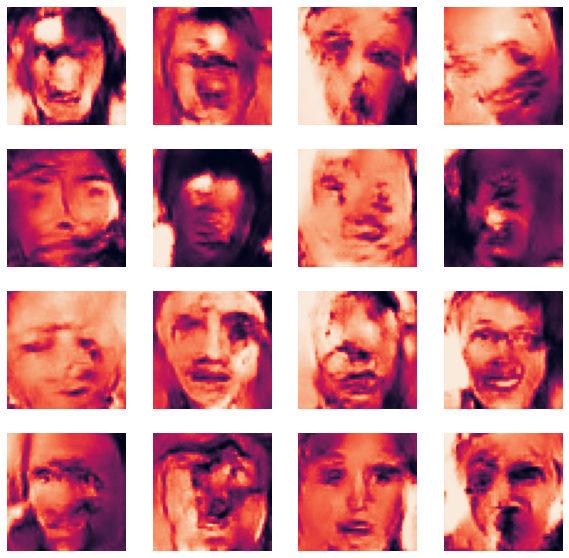

epochs:  9
2/2 [==============================] - 0s 9ms/step


In [ ]:
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs= 100) 

In [ ]:
import imageio
import glob

anim_file = './dcgan_face.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./produced_images_epoch_*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

from IPython.display import Image
Image(open(anim_file,'rb').read())

## Reference
 
* https://github.com/bnsreenu/python_for_microscopists/blob/master/248_keras_implementation_of_GAN/248-cifar_GAN.py

* https://github.com/ayyucekizrak/GAN_UreticiCekismeliAglar_ile_SentetikVeriUretme

* https://www.tensorflow.org/tutorials/generative/dcgan

**Prepared by Nurullah Yuksel**